**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_1_)    
  - [Visualize the data](#toc1_2_)    
  - [Prepare data](#toc1_3_)    
    - [Files operations](#toc1_3_1_)    
    - [Data operations](#toc1_3_2_)    
    - [Train / test / validation split](#toc1_3_3_)    
  - [Model](#toc1_4_)    
- [Instances](#toc2_)    
  - [Glove Twitter](#toc2_1_)    
  - [Glove 6B - 50d](#toc2_2_)    
  - [Glove 6B - 100d](#toc2_3_)    
  - [Glove 43B](#toc2_4_)    
- [Conclusion](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports](#toc0_)

In [54]:
import torch
from torch import nn
from torch import Tensor
import torch.optim as optim
from tqdm import tqdm
import torchtext
import torchtext.data
import re

torch.cuda.is_available()

True

In [55]:
from torchnlp.encoders.text import StaticTokenizerEncoder
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd
import os

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## <a id='toc1_2_'></a>[Visualize the data](#toc0_)

In [57]:
import matplotlib.pyplot as plt

def plot_history(train_acc_history, train_loss_history, val_acc_history, val_loss_history):
    epochs = range(1, len(train_loss_history) + 1)
    
    # Loss
    plt.figure(1)
    plt.plot(epochs, train_loss_history, 'b', label='Training loss (' + str(format(train_loss_history[-1], '.5f')) + ')')
    plt.plot(epochs, val_loss_history, 'g', label='Validation loss (' + str(format(val_loss_history[-1], '.5f')) + ')')
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.figure(2)
    plt.plot(epochs, train_acc_history, 'b', label='Training accuracy (' + str(format(train_acc_history[-1], '.5f')) + ')')
    plt.plot(epochs, val_acc_history, 'g', label='Validation accuracy (' + str(format(val_acc_history[-1], '.5f')) + ')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


## <a id='toc1_3_'></a>[Prepare data](#toc0_)

### <a id='toc1_3_1_'></a>[Files operations](#toc0_)

In [58]:
def read_glove_file(path: str) -> dict[str, np.ndarray]:
    embeddings: dict = {}
    f = open(path, encoding ="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings))

    return embeddings

In [59]:
def read_imdb() -> tuple[list[str], list[int]]:
    imdb_dir = 'kaggle/Imdb/'
    train_dir = imdb_dir + 'train/'

    labels = []
    texts = []

    for label_type in ['neg', 'pos']:
        dir_name = train_dir + label_type
        for fname in os.listdir(dir_name):
            if fname[-4:] == '.txt':
                f = open(os.path.join(dir_name, fname), encoding ="utf8")
                texts.append(f.read())
                f.close()
                if label_type == 'neg':
                    labels.append(0)
                else:
                    labels.append(1)

    return texts, labels

In [60]:
texts, labels = read_imdb()

### <a id='toc1_3_2_'></a>[Data operations](#toc0_)

In [61]:
def texts_to_sequences(texts: list[str], maxlen: int, max_words: int, embeddings:dict[str, np.ndarray]) -> tuple[torch.Tensor, dict[any, int]]:
    texts = [text.lower() for text in texts]
    tokenizer = StaticTokenizerEncoder(texts, tokenize=lambda s: re.findall(r'([a-zA-Z0-9]+|[\.,;\/\\\'])', s), min_occurrences=1)
    
    sequences = [tokenizer.encode(text) for text in texts]
    word_index = tokenizer.vocab
    word_index_dict = {word: index for index, word in enumerate(word_index)}
    index_word = {index: word for word, index in word_index_dict.items()}
    
    sequences = [[word for word in seq if index_word[word.item()] in embeddings] for seq in sequences]
    
    data = torch.zeros((len(sequences), maxlen), dtype=torch.long)
    
    for i, seq in enumerate(sequences):
        for j, word in enumerate(seq):            
            if j >= maxlen:
                break
            if word < max_words:
                data[i, j] = word
            else:
                data[i, j] = 0

    print([index_word[word.item()] for word in data[0] if word != 0])
    return data, word_index_dict

In [62]:
def get_embedding_matrix(max_words: int, embedding_index: dict[str, np.ndarray], word_index: dict[any, int]) -> np.ndarray:
    embedding_dimension = embedding_index.get('the').shape[0]

    embedding_matrix = np.zeros((max_words, embedding_dimension))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                # Words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [63]:
def split_data(data: np.ndarray, labels: list[int], train_part: float, validation_part: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    labels = np.asarray(labels)

    data_size = data.shape[0]
    train_size = int(data_size * train_part)
    validation_size = int(data_size * validation_part)
    test_size = data_size - train_size - validation_size

    indices = np.arange(data_size)
    np.random.shuffle(indices)

    train_indices = indices[:train_size]
    validation_indices = indices[train_size:train_size + validation_size]
    test_indices = indices[train_size + validation_size:]

    train_data = data[train_indices]
    validation_data = data[validation_indices]
    test_data = data[test_indices]

    train_labels = labels[train_indices]
    validation_labels = labels[validation_indices]
    test_labels = labels[test_indices]

    print(f"Train data size: {train_data.shape[0]}")
    print(f"Validation data size: {validation_data.shape[0]}")
    print(f"Test data size: {test_data.shape[0]}")

    return train_data, validation_data, test_data, train_labels, validation_labels, test_labels

### <a id='toc1_3_3_'></a>[Train / test / validation split](#toc0_)

In [64]:
def prepare_data_for_model(maxlen: int, max_words: int, embeddings: dict[str, np.ndarray], texts: list[str], labels: list[int], train_part: float, validation_part: float) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, dict[any, int], np.ndarray]:
    data, word_index = texts_to_sequences(texts, maxlen=maxlen, max_words=max_words, embeddings=embeddings)
    embedding_matrix = get_embedding_matrix(max_words, embeddings, word_index)
    train_data, validation_data, test_data, train_labels, validation_labels, test_labels = split_data(data, labels, train_part, validation_part)
    return train_data, validation_data, test_data, train_labels, validation_labels, test_labels, word_index, embedding_matrix


## <a id='toc1_4_'></a>[Model](#toc0_)

In [65]:
EPOCHS: int = 30

In [66]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size: int, embed_size: int, maxlen: int):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.conv = nn.Conv1d(embed_size, 16, kernel_size=7)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=4)
        self.batch_norm = nn.BatchNorm1d(num_features=16)
        conv_output_size = (maxlen - 6) // 4
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(16 * conv_output_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def set_embedding(self, embedding_matrix: np.ndarray) -> None:
        assert self.embedding.weight.shape == embedding_matrix.shape, "Embedding matrix shape mismatch"
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        print("Embedding shape:", self.embedding.weight.data.shape)
        
    def forward(self, x: Tensor) -> Tensor:
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Conv1d - change shape to [batch_size, embed_size, seq_len] 
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.batch_norm(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [67]:
class RecurrentClassificationModelLSTM(nn.Module):
    def __init__(self, vocab_size: int, embed_size: int, maxlen: int, hidden_size: int):
        super(RecurrentClassificationModelLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=3, batch_first=True, bidirectional=True)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(hidden_size*2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def set_embedding(self, embedding_matrix: np.ndarray) -> None:
        print("Expected embedding shape:", self.embedding.weight.shape)
        print("Provided embedding matrix shape:", embedding_matrix.shape)
        assert self.embedding.weight.shape == embedding_matrix.shape, "Embedding matrix shape mismatch"
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        print("Embedding shape:", self.embedding.weight.data.shape)
        
    def forward(self, x: Tensor) -> Tensor:
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [68]:
def train_model(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer,
                train_loader: torch.utils.data.DataLoader, validation_loader: torch.utils.data.DataLoader) -> tuple[list[float], list[float], list[float], list[float]]:
    model.to(device)
    criterion.to(device)
    accuracy_history: list = []
    loss_history: list = []
    val_accuracy_history: list = []
    val_loss_history: list = []
    
    print("Training model...")
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = (output > 0.5).float()
            total += target.size(0)
            correct += (predicted == target.float().view(-1, 1)).sum().item()
        accuracy = correct / total
        loss_history.append(train_loss / len(train_loader))
        accuracy_history.append(accuracy)
        
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target.float().view(-1, 1))
                val_loss += loss.item()
                predicted = (output > 0.5).float()
                total += target.size(0)
                correct += (predicted == target.float().view(-1, 1)).sum().item()
        val_accuracy = correct / total
        val_loss_history.append(val_loss / len(validation_loader))
        val_accuracy_history.append(val_accuracy)
        
        print(f"Epoch {epoch + 1}/{EPOCHS}:")
        print(f"Train loss: {loss_history[-1]}, accuracy: {accuracy}")
        print(f"Validation loss: {val_loss_history[-1]}, accuracy: {val_accuracy}")
        
    return accuracy_history, loss_history, val_accuracy_history, val_loss_history
        

In [69]:
def test_model(model: nn.Module, criterion: nn.Module, test_loader: torch.utils.data.DataLoader) -> tuple[float, float]:
    model.to(device)
    correct = 0
    total = 0
    total_loss = 0
    model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target.float().view(-1, 1))
        total_loss += loss.item()
        predicted = (output > 0.5).float()
        total += target.size(0)
        correct += (predicted == target.float().view(-1, 1)).sum().item()
        
    accuracy = correct / total
    loss = total_loss / len(test_loader)
    
    print(f"Test accuracy: {accuracy}")
    print(f"Test loss: {loss}")
    
    return accuracy, loss

# <a id='toc2_'></a>[Instances](#toc0_)

## <a id='toc2_1_'></a>[Glove Twitter](#toc0_)

In [70]:
embeddings = read_glove_file('kaggle/glove.twitter.27B/glove.twitter.27B.100d.txt')
train_data, validation_data, test_data, train_labels, validation_labels, test_labels, word_index, embedding_matrix = prepare_data_for_model(maxlen=250, max_words=100000, embeddings=embeddings, texts=texts, labels=labels, train_part=0.8, validation_part=0.1)

Found 1193514 word vectors.
['i', 'cannot', 'for', 'the', 'life', 'of', 'me', 'explain', 'what', 'the', 'popularity', 'of', 'the', 'children', "'", 's', 'television', 'show', ',', 'power', 'rangers', 'is', 'all', 'about', '.', 'br', '/', 'br', '/', 'i', 'never', 'understood', 'why', 'unsuspecting', 'children', 'liked', 'this', 'show', 'in', 'the', 'first', 'place', ',', 'since', 'the', 'characters', 'seem', 'so', 'idiotic', 'and', 'not', 'worth', 'caring', 'about', 'whatsoever', '.', 'br', '/', 'br', '/', 'the', 'costumes', 'look', 'completely', 'atrocious', ',', 'like', 'multi', 'colored', 'spandex', 'that', 'people', 'wear', 'to', 'go', 'to', 'the', 'gym', '.', 'br', '/', 'br', '/', 'what', 'exactly', 'is', 'the', 'purpose', 'of', 'this', 'show', 'anyways', ',', 'but', 'for', 'kids', 'to', 'learn', 'how', 'to', 'fight', 'to', 'solve', 'their', 'problems', 'what', 'is', 'up', 'with', 'the', 'awful', 'hair', 'cuts', ',', 'and', 'clothing', 'on', 'this', 'show', 'anyway', 'not', 'to', '

In [71]:
train_dataset = torch.utils.data.TensorDataset(train_data, torch.tensor(train_labels, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(validation_data, torch.tensor(validation_labels, dtype=torch.long))
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(test_data, torch.tensor(test_labels, dtype=torch.long))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [72]:
model = RecurrentClassificationModelLSTM(vocab_size=100000, embed_size=100, maxlen=250, hidden_size=64)
model.set_embedding(embedding_matrix)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
accuracy_history, loss_history, val_accuracy_history, val_loss_history = train_model(model, criterion, optimizer, train_loader, validation_loader)

Expected embedding shape: torch.Size([100000, 100])
Provided embedding matrix shape: (100000, 100)
Embedding shape: torch.Size([100000, 100])
Training model...


100%|██████████| 625/625 [00:08<00:00, 72.63it/s]


Epoch 1/30:
Train loss: 0.6888823090553283, accuracy: 0.529
Validation loss: 0.7197940651374527, accuracy: 0.5228


100%|██████████| 625/625 [00:08<00:00, 77.71it/s]


Epoch 2/30:
Train loss: 0.6831133058547973, accuracy: 0.5433
Validation loss: 0.6200368691094315, accuracy: 0.7048


100%|██████████| 625/625 [00:08<00:00, 77.79it/s]


Epoch 3/30:
Train loss: 0.6391305849552155, accuracy: 0.6345
Validation loss: 0.5333050285713582, accuracy: 0.7376


100%|██████████| 625/625 [00:08<00:00, 77.93it/s]


Epoch 4/30:
Train loss: 0.4940158203125, accuracy: 0.7764
Validation loss: 0.43718217803707604, accuracy: 0.7968


100%|██████████| 625/625 [00:07<00:00, 78.17it/s]


Epoch 5/30:
Train loss: 0.3871844227671623, accuracy: 0.83165
Validation loss: 0.36557447042646285, accuracy: 0.8444


100%|██████████| 625/625 [00:08<00:00, 77.73it/s]


Epoch 6/30:
Train loss: 0.34814649288654326, accuracy: 0.8473
Validation loss: 0.3375241309875929, accuracy: 0.848


100%|██████████| 625/625 [00:08<00:00, 77.99it/s]


Epoch 7/30:
Train loss: 0.3270179309129715, accuracy: 0.85725
Validation loss: 0.32462612350907505, accuracy: 0.8556


100%|██████████| 625/625 [00:07<00:00, 78.30it/s]


Epoch 8/30:
Train loss: 0.31275560014247894, accuracy: 0.8656
Validation loss: 0.32967754066744936, accuracy: 0.8596


100%|██████████| 625/625 [00:07<00:00, 78.26it/s]


Epoch 9/30:
Train loss: 0.2972078414797783, accuracy: 0.8753
Validation loss: 0.32177480131010466, accuracy: 0.8588


100%|██████████| 625/625 [00:07<00:00, 78.42it/s]


Epoch 10/30:
Train loss: 0.2813405394792557, accuracy: 0.88365
Validation loss: 0.31489221497049813, accuracy: 0.8692


100%|██████████| 625/625 [00:07<00:00, 78.17it/s]


Epoch 11/30:
Train loss: 0.2685580547273159, accuracy: 0.88735
Validation loss: 0.3118777432585064, accuracy: 0.8664


100%|██████████| 625/625 [00:07<00:00, 78.24it/s]


Epoch 12/30:
Train loss: 0.25566317328214644, accuracy: 0.89545
Validation loss: 0.3111612848654578, accuracy: 0.87


100%|██████████| 625/625 [00:08<00:00, 78.02it/s]


Epoch 13/30:
Train loss: 0.24026802584528922, accuracy: 0.90205
Validation loss: 0.34910873936701425, accuracy: 0.8544


100%|██████████| 625/625 [00:08<00:00, 72.24it/s]


Epoch 14/30:
Train loss: 0.22512318519949914, accuracy: 0.9084
Validation loss: 0.34555621605507936, accuracy: 0.8712


100%|██████████| 625/625 [00:08<00:00, 77.38it/s]


Epoch 15/30:
Train loss: 0.20958418736457823, accuracy: 0.9182
Validation loss: 0.3311932831059528, accuracy: 0.8732


100%|██████████| 625/625 [00:07<00:00, 78.50it/s]


Epoch 16/30:
Train loss: 0.19575648884177207, accuracy: 0.9251
Validation loss: 0.3375843039041833, accuracy: 0.8724


100%|██████████| 625/625 [00:07<00:00, 78.18it/s]


Epoch 17/30:
Train loss: 0.17528389169871808, accuracy: 0.93195
Validation loss: 0.34198058726666847, accuracy: 0.8692


100%|██████████| 625/625 [00:07<00:00, 78.25it/s]


Epoch 18/30:
Train loss: 0.15871232460737228, accuracy: 0.9409
Validation loss: 0.36093755085257034, accuracy: 0.8676


100%|██████████| 625/625 [00:08<00:00, 77.89it/s]


Epoch 19/30:
Train loss: 0.1431114978685975, accuracy: 0.9473
Validation loss: 0.36113091157395627, accuracy: 0.8672


100%|██████████| 625/625 [00:08<00:00, 77.66it/s]


Epoch 20/30:
Train loss: 0.12635087260901928, accuracy: 0.95355
Validation loss: 0.43521398874117606, accuracy: 0.8476


100%|██████████| 625/625 [00:08<00:00, 77.75it/s]


Epoch 21/30:
Train loss: 0.10930966841503978, accuracy: 0.96175
Validation loss: 0.4458653062959261, accuracy: 0.8668


100%|██████████| 625/625 [00:07<00:00, 78.41it/s]


Epoch 22/30:
Train loss: 0.09109265222847461, accuracy: 0.96845
Validation loss: 0.4631990966728971, accuracy: 0.8636


100%|██████████| 625/625 [00:07<00:00, 78.56it/s]


Epoch 23/30:
Train loss: 0.07899210675302892, accuracy: 0.974
Validation loss: 0.49967664866885053, accuracy: 0.8664


100%|██████████| 625/625 [00:07<00:00, 78.33it/s]


Epoch 24/30:
Train loss: 0.06760929805897176, accuracy: 0.97775
Validation loss: 0.5626572248160462, accuracy: 0.8608


100%|██████████| 625/625 [00:07<00:00, 78.31it/s]


Epoch 25/30:
Train loss: 0.06268719983957707, accuracy: 0.9807
Validation loss: 0.6120454170446419, accuracy: 0.8552


100%|██████████| 625/625 [00:08<00:00, 77.78it/s]


Epoch 26/30:
Train loss: 0.05769615652561188, accuracy: 0.9821
Validation loss: 0.5336239944341816, accuracy: 0.8588


100%|██████████| 625/625 [00:08<00:00, 78.06it/s]


Epoch 27/30:
Train loss: 0.048770880534499884, accuracy: 0.98445
Validation loss: 0.6274478298595729, accuracy: 0.8548


100%|██████████| 625/625 [00:08<00:00, 77.75it/s]


Epoch 28/30:
Train loss: 0.0470671556673944, accuracy: 0.98535
Validation loss: 0.6456237443003662, accuracy: 0.848


100%|██████████| 625/625 [00:08<00:00, 77.73it/s]


Epoch 29/30:
Train loss: 0.04185008794805035, accuracy: 0.9877
Validation loss: 0.7157354703013892, accuracy: 0.86


100%|██████████| 625/625 [00:08<00:00, 77.60it/s]


Epoch 30/30:
Train loss: 0.037625089647993444, accuracy: 0.98905
Validation loss: 0.657402078179006, accuracy: 0.8708


In [73]:
test_model(model, criterion, test_loader)

Test accuracy: 0.8452
Test loss: 0.7193827166021625


(0.8452, 0.7193827166021625)

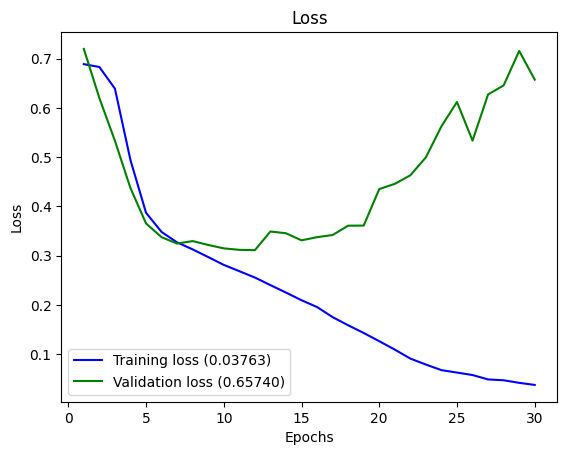

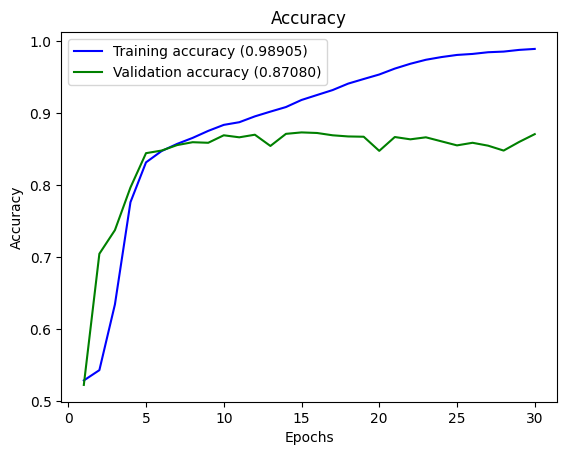

In [74]:
plot_history(accuracy_history, loss_history, val_accuracy_history, val_loss_history)

## <a id='toc2_2_'></a>[Glove 6B - 50d](#toc0_)

In [75]:
embeddings = read_glove_file('kaggle/glove.6B/glove.6B.50d.txt')
train_data, validation_data, test_data, train_labels, validation_labels, test_labels, word_index, embedding_matrix = prepare_data_for_model(maxlen=100, max_words=10000, embeddings=embeddings, texts=texts, labels=labels, train_part=0.8, validation_part=0.1)

Found 400000 word vectors.
['i', 'cannot', 'for', 'the', 'life', 'of', 'me', 'explain', 'what', 'the', 'popularity', 'of', 'the', 'children', "'", 's', 'television', 'show', ',', 'power', 'rangers', 'is', 'all', 'about', '.', 'br', '/', 'br', '/', 'i', 'never', 'understood', 'why', 'unsuspecting', 'children', 'liked', 'this', 'show', 'in', 'the', 'first', 'place', ',', 'since', 'the', 'characters', 'seem', 'so', 'idiotic', 'and', 'not', 'worth', 'caring', 'about', 'whatsoever', '.', 'br', '/', 'br', '/', 'the', 'costumes', 'look', 'completely', 'atrocious', ',', 'like', 'multi', 'colored', 'spandex', 'that', 'people', 'wear', 'to', 'go', 'to', 'the', 'gym', '.', 'br', '/', 'br', '/', 'what', 'exactly', 'is', 'the', 'purpose', 'of', 'this', 'show', 'anyways', ',', 'but', 'for', 'kids', 'to', 'learn', 'how', 'to']
Train data size: 20000
Validation data size: 2500
Test data size: 2500


In [76]:
train_dataset = torch.utils.data.TensorDataset(train_data, torch.tensor(train_labels, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(validation_data, torch.tensor(validation_labels, dtype=torch.long))
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(test_data, torch.tensor(test_labels, dtype=torch.long))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [77]:
model = RecurrentClassificationModelLSTM(vocab_size=10000, embed_size=50, maxlen=1000, hidden_size=64)
model.set_embedding(embedding_matrix)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
accuracy_history, loss_history, val_accuracy_history, val_loss_history = train_model(model, criterion, optimizer, train_loader, validation_loader)

Expected embedding shape: torch.Size([10000, 50])
Provided embedding matrix shape: (10000, 50)
Embedding shape: torch.Size([10000, 50])
Training model...


100%|██████████| 625/625 [00:04<00:00, 130.94it/s]


Epoch 1/30:
Train loss: 0.6831320189476013, accuracy: 0.56075
Validation loss: 0.678927892371069, accuracy: 0.5772


100%|██████████| 625/625 [00:04<00:00, 131.50it/s]


Epoch 2/30:
Train loss: 0.6638649059295654, accuracy: 0.60485
Validation loss: 0.6281104050105131, accuracy: 0.65


100%|██████████| 625/625 [00:04<00:00, 143.87it/s]


Epoch 3/30:
Train loss: 0.6186682770729065, accuracy: 0.66685
Validation loss: 0.560491423440885, accuracy: 0.722


100%|██████████| 625/625 [00:04<00:00, 144.67it/s]


Epoch 4/30:
Train loss: 0.5786557503700256, accuracy: 0.70325
Validation loss: 0.579005659003801, accuracy: 0.6892


100%|██████████| 625/625 [00:04<00:00, 145.28it/s]


Epoch 5/30:
Train loss: 0.5499064263820648, accuracy: 0.72325
Validation loss: 0.5208019304879105, accuracy: 0.7476


100%|██████████| 625/625 [00:04<00:00, 144.94it/s]


Epoch 6/30:
Train loss: 0.5225670910358429, accuracy: 0.74055
Validation loss: 0.4989546733566477, accuracy: 0.7636


100%|██████████| 625/625 [00:04<00:00, 144.45it/s]


Epoch 7/30:
Train loss: 0.5075370067596435, accuracy: 0.75395
Validation loss: 0.48647960756398456, accuracy: 0.7724


100%|██████████| 625/625 [00:04<00:00, 143.34it/s]


Epoch 8/30:
Train loss: 0.4852357530593872, accuracy: 0.7662
Validation loss: 0.4679418932410735, accuracy: 0.778


100%|██████████| 625/625 [00:04<00:00, 146.61it/s]


Epoch 9/30:
Train loss: 0.47412534313201904, accuracy: 0.7663
Validation loss: 0.45471801146676266, accuracy: 0.7828


100%|██████████| 625/625 [00:04<00:00, 146.46it/s]


Epoch 10/30:
Train loss: 0.45878018765449524, accuracy: 0.78385
Validation loss: 0.44908782349357124, accuracy: 0.7956


100%|██████████| 625/625 [00:04<00:00, 145.04it/s]


Epoch 11/30:
Train loss: 0.45815297503471375, accuracy: 0.7779
Validation loss: 0.4372240482251855, accuracy: 0.8036


100%|██████████| 625/625 [00:04<00:00, 146.65it/s]


Epoch 12/30:
Train loss: 0.43888454217910766, accuracy: 0.78975
Validation loss: 0.43300488176225105, accuracy: 0.806


100%|██████████| 625/625 [00:04<00:00, 147.06it/s]


Epoch 13/30:
Train loss: 0.4266614262104034, accuracy: 0.79765
Validation loss: 0.42473246100582657, accuracy: 0.8012


100%|██████████| 625/625 [00:04<00:00, 146.64it/s]


Epoch 14/30:
Train loss: 0.41753681285381317, accuracy: 0.80325
Validation loss: 0.4455894765597356, accuracy: 0.7952


100%|██████████| 625/625 [00:04<00:00, 145.92it/s]


Epoch 15/30:
Train loss: 0.4124174790382385, accuracy: 0.80695
Validation loss: 0.4245345371810696, accuracy: 0.8052


100%|██████████| 625/625 [00:04<00:00, 141.41it/s]


Epoch 16/30:
Train loss: 0.39976707684993745, accuracy: 0.8116
Validation loss: 0.4283036197288127, accuracy: 0.8012


100%|██████████| 625/625 [00:04<00:00, 134.43it/s]


Epoch 17/30:
Train loss: 0.39277902119159697, accuracy: 0.81705
Validation loss: 0.41459507825253883, accuracy: 0.8136


100%|██████████| 625/625 [00:04<00:00, 140.81it/s]


Epoch 18/30:
Train loss: 0.3778975890636444, accuracy: 0.82525
Validation loss: 0.4203626370128197, accuracy: 0.7976


100%|██████████| 625/625 [00:04<00:00, 144.87it/s]


Epoch 19/30:
Train loss: 0.37061596360206606, accuracy: 0.83005
Validation loss: 0.42894204691806925, accuracy: 0.7984


100%|██████████| 625/625 [00:04<00:00, 134.47it/s]


Epoch 20/30:
Train loss: 0.3591456587553024, accuracy: 0.83335
Validation loss: 0.42780060236212575, accuracy: 0.8072


100%|██████████| 625/625 [00:04<00:00, 136.78it/s]


Epoch 21/30:
Train loss: 0.34012065796852115, accuracy: 0.84215
Validation loss: 0.4295993413351759, accuracy: 0.8148


100%|██████████| 625/625 [00:04<00:00, 137.41it/s]


Epoch 22/30:
Train loss: 0.3316460352420807, accuracy: 0.84565
Validation loss: 0.445520975638794, accuracy: 0.8088


100%|██████████| 625/625 [00:04<00:00, 126.34it/s]


Epoch 23/30:
Train loss: 0.31353648991584776, accuracy: 0.85495
Validation loss: 0.4726164525822748, accuracy: 0.8004


100%|██████████| 625/625 [00:04<00:00, 130.66it/s]


Epoch 24/30:
Train loss: 0.30155776656866073, accuracy: 0.86115
Validation loss: 0.4719216087950936, accuracy: 0.8068


100%|██████████| 625/625 [00:04<00:00, 132.27it/s]


Epoch 25/30:
Train loss: 0.28249993596076967, accuracy: 0.86975
Validation loss: 0.5111209545520288, accuracy: 0.7812


100%|██████████| 625/625 [00:04<00:00, 130.86it/s]


Epoch 26/30:
Train loss: 0.26478264387845996, accuracy: 0.8785
Validation loss: 0.4896976940239532, accuracy: 0.8028


100%|██████████| 625/625 [00:04<00:00, 131.66it/s]


Epoch 27/30:
Train loss: 0.24311078547239304, accuracy: 0.89
Validation loss: 0.5981346515915061, accuracy: 0.7844


100%|██████████| 625/625 [00:04<00:00, 131.38it/s]


Epoch 28/30:
Train loss: 0.2317724326312542, accuracy: 0.89425
Validation loss: 0.5557245896021022, accuracy: 0.792


100%|██████████| 625/625 [00:04<00:00, 130.84it/s]


Epoch 29/30:
Train loss: 0.21290839796066285, accuracy: 0.90675
Validation loss: 0.5925967182162442, accuracy: 0.7892


100%|██████████| 625/625 [00:04<00:00, 131.53it/s]


Epoch 30/30:
Train loss: 0.20001777466535567, accuracy: 0.9123
Validation loss: 0.5966285595882542, accuracy: 0.7956


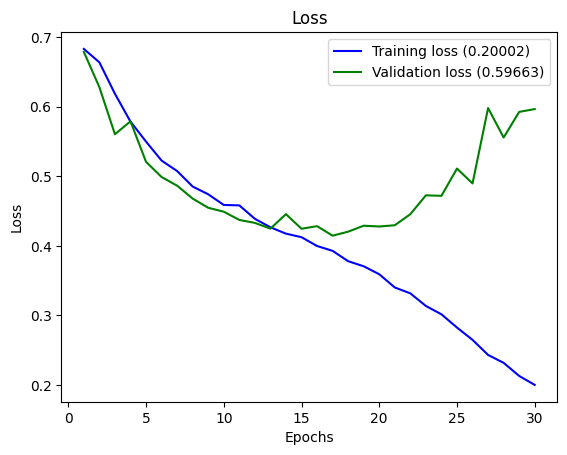

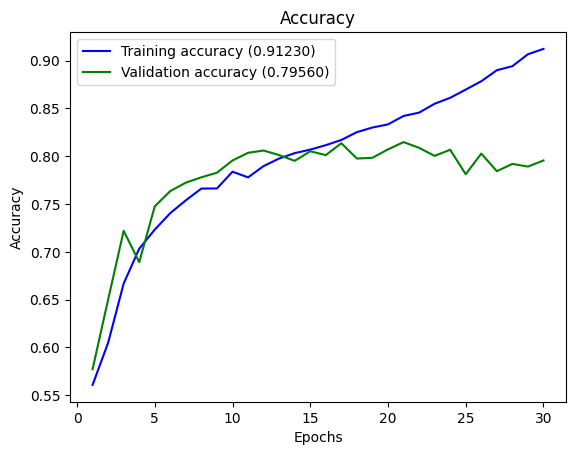

In [78]:
plot_history(accuracy_history, loss_history, val_accuracy_history, val_loss_history)

## <a id='toc2_3_'></a>[Glove 6B - 100d](#toc0_)

In [79]:
embeddings = read_glove_file('kaggle/glove.6B/glove.6B.100d.txt')
train_data, validation_data, test_data, train_labels, validation_labels, test_labels, word_index, embedding_matrix = prepare_data_for_model(maxlen=100, max_words=10000, embeddings=embeddings, texts=texts, labels=labels, train_part=0.8, validation_part=0.1)

Found 400000 word vectors.
['i', 'cannot', 'for', 'the', 'life', 'of', 'me', 'explain', 'what', 'the', 'popularity', 'of', 'the', 'children', "'", 's', 'television', 'show', ',', 'power', 'rangers', 'is', 'all', 'about', '.', 'br', '/', 'br', '/', 'i', 'never', 'understood', 'why', 'unsuspecting', 'children', 'liked', 'this', 'show', 'in', 'the', 'first', 'place', ',', 'since', 'the', 'characters', 'seem', 'so', 'idiotic', 'and', 'not', 'worth', 'caring', 'about', 'whatsoever', '.', 'br', '/', 'br', '/', 'the', 'costumes', 'look', 'completely', 'atrocious', ',', 'like', 'multi', 'colored', 'spandex', 'that', 'people', 'wear', 'to', 'go', 'to', 'the', 'gym', '.', 'br', '/', 'br', '/', 'what', 'exactly', 'is', 'the', 'purpose', 'of', 'this', 'show', 'anyways', ',', 'but', 'for', 'kids', 'to', 'learn', 'how', 'to']
Train data size: 20000
Validation data size: 2500
Test data size: 2500


In [80]:
train_dataset = torch.utils.data.TensorDataset(train_data, torch.tensor(train_labels, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(validation_data, torch.tensor(validation_labels, dtype=torch.long))
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(test_data, torch.tensor(test_labels, dtype=torch.long))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [81]:
model = RecurrentClassificationModelLSTM(vocab_size=10000, embed_size=100, maxlen=1000, hidden_size=64)
model.set_embedding(embedding_matrix)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
accuracy_history, loss_history, val_accuracy_history, val_loss_history = train_model(model, criterion, optimizer, train_loader, validation_loader)

Expected embedding shape: torch.Size([10000, 100])
Provided embedding matrix shape: (10000, 100)
Embedding shape: torch.Size([10000, 100])
Training model...


100%|██████████| 625/625 [00:05<00:00, 119.92it/s]


Epoch 1/30:
Train loss: 0.6782915581703186, accuracy: 0.56345
Validation loss: 0.6882890523234501, accuracy: 0.5208


100%|██████████| 625/625 [00:05<00:00, 123.71it/s]


Epoch 2/30:
Train loss: 0.6835200554847717, accuracy: 0.55975
Validation loss: 0.6386545768266991, accuracy: 0.654


100%|██████████| 625/625 [00:04<00:00, 127.77it/s]


Epoch 3/30:
Train loss: 0.600954077911377, accuracy: 0.6831
Validation loss: 0.5359003441997722, accuracy: 0.7432


100%|██████████| 625/625 [00:04<00:00, 126.13it/s]


Epoch 4/30:
Train loss: 0.5421126235961914, accuracy: 0.7312
Validation loss: 0.5082502251938928, accuracy: 0.7556


100%|██████████| 625/625 [00:04<00:00, 129.17it/s]


Epoch 5/30:
Train loss: 0.4922247874736786, accuracy: 0.76525
Validation loss: 0.46944274102585226, accuracy: 0.774


100%|██████████| 625/625 [00:04<00:00, 130.19it/s]


Epoch 6/30:
Train loss: 0.4599805784702301, accuracy: 0.7822
Validation loss: 0.4484650153148023, accuracy: 0.7868


100%|██████████| 625/625 [00:04<00:00, 130.40it/s]


Epoch 7/30:
Train loss: 0.4336458224773407, accuracy: 0.796
Validation loss: 0.46969029175329813, accuracy: 0.7676


100%|██████████| 625/625 [00:04<00:00, 130.64it/s]


Epoch 8/30:
Train loss: 0.4151472836494446, accuracy: 0.80835
Validation loss: 0.42537267449535904, accuracy: 0.806


100%|██████████| 625/625 [00:04<00:00, 130.96it/s]


Epoch 9/30:
Train loss: 0.40523111646175386, accuracy: 0.81205
Validation loss: 0.4217677216363859, accuracy: 0.808


100%|██████████| 625/625 [00:04<00:00, 130.47it/s]


Epoch 10/30:
Train loss: 0.3901643826961517, accuracy: 0.82175
Validation loss: 0.42061356577692155, accuracy: 0.8084


100%|██████████| 625/625 [00:04<00:00, 130.44it/s]


Epoch 11/30:
Train loss: 0.3733590476512909, accuracy: 0.83225
Validation loss: 0.423150865526139, accuracy: 0.8096


100%|██████████| 625/625 [00:04<00:00, 129.75it/s]


Epoch 12/30:
Train loss: 0.36040050926208494, accuracy: 0.8362
Validation loss: 0.43785774915278713, accuracy: 0.794


100%|██████████| 625/625 [00:04<00:00, 129.47it/s]


Epoch 13/30:
Train loss: 0.3470826303124428, accuracy: 0.8481
Validation loss: 0.4183034453588196, accuracy: 0.812


100%|██████████| 625/625 [00:04<00:00, 129.52it/s]


Epoch 14/30:
Train loss: 0.33180207979679105, accuracy: 0.8557
Validation loss: 0.4123199212400219, accuracy: 0.816


100%|██████████| 625/625 [00:04<00:00, 130.42it/s]


Epoch 15/30:
Train loss: 0.3163269607901573, accuracy: 0.8626
Validation loss: 0.4181971458505981, accuracy: 0.8068


100%|██████████| 625/625 [00:04<00:00, 129.92it/s]


Epoch 16/30:
Train loss: 0.3554385819196701, accuracy: 0.8432
Validation loss: 0.44268111717191677, accuracy: 0.8076


100%|██████████| 625/625 [00:04<00:00, 129.41it/s]


Epoch 17/30:
Train loss: 0.30548782469034197, accuracy: 0.869
Validation loss: 0.44279883801937103, accuracy: 0.8108


100%|██████████| 625/625 [00:04<00:00, 129.31it/s]


Epoch 18/30:
Train loss: 0.28758759667873385, accuracy: 0.87845
Validation loss: 0.4755985954705673, accuracy: 0.8008


100%|██████████| 625/625 [00:04<00:00, 129.30it/s]


Epoch 19/30:
Train loss: 0.2636743129789829, accuracy: 0.8913
Validation loss: 0.491599306935751, accuracy: 0.8068


100%|██████████| 625/625 [00:04<00:00, 129.68it/s]


Epoch 20/30:
Train loss: 0.24700859560966493, accuracy: 0.8991
Validation loss: 0.4900270436383501, accuracy: 0.7912


100%|██████████| 625/625 [00:04<00:00, 128.60it/s]


Epoch 21/30:
Train loss: 0.2286359613239765, accuracy: 0.90815
Validation loss: 0.4979700729062286, accuracy: 0.8016


100%|██████████| 625/625 [00:04<00:00, 129.36it/s]


Epoch 22/30:
Train loss: 0.21017942910790444, accuracy: 0.9166
Validation loss: 0.5112120556303218, accuracy: 0.7976


100%|██████████| 625/625 [00:04<00:00, 129.13it/s]


Epoch 23/30:
Train loss: 0.18944274168610573, accuracy: 0.9264
Validation loss: 0.5748290954086976, accuracy: 0.8008


100%|██████████| 625/625 [00:04<00:00, 129.88it/s]


Epoch 24/30:
Train loss: 0.17023292573690416, accuracy: 0.93485
Validation loss: 0.57577636068734, accuracy: 0.7948


100%|██████████| 625/625 [00:04<00:00, 129.30it/s]


Epoch 25/30:
Train loss: 0.1474397384122014, accuracy: 0.945
Validation loss: 0.6150784292435155, accuracy: 0.7924


100%|██████████| 625/625 [00:04<00:00, 128.38it/s]


Epoch 26/30:
Train loss: 0.14237562803030013, accuracy: 0.9487
Validation loss: 0.6766168195990068, accuracy: 0.796


100%|██████████| 625/625 [00:04<00:00, 128.94it/s]


Epoch 27/30:
Train loss: 0.12010407608300447, accuracy: 0.95675
Validation loss: 0.7596706827230091, accuracy: 0.7876


100%|██████████| 625/625 [00:04<00:00, 129.21it/s]


Epoch 28/30:
Train loss: 0.10058568315953016, accuracy: 0.966
Validation loss: 0.7548911926112597, accuracy: 0.7836


100%|██████████| 625/625 [00:04<00:00, 129.34it/s]


Epoch 29/30:
Train loss: 0.09322807398363948, accuracy: 0.96785
Validation loss: 0.8289817623275367, accuracy: 0.7908


100%|██████████| 625/625 [00:04<00:00, 128.71it/s]


Epoch 30/30:
Train loss: 0.08769122313261032, accuracy: 0.97015
Validation loss: 0.7919714677182934, accuracy: 0.7916


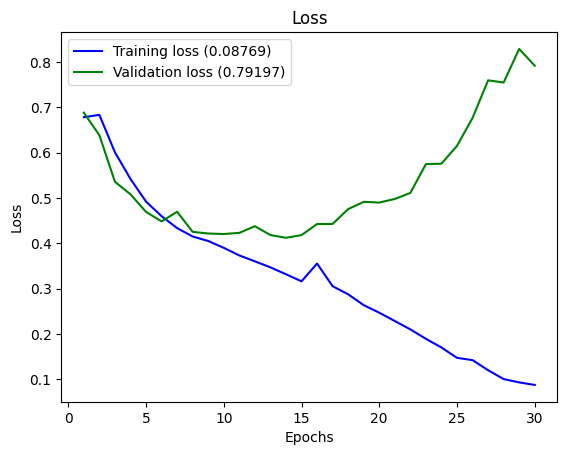

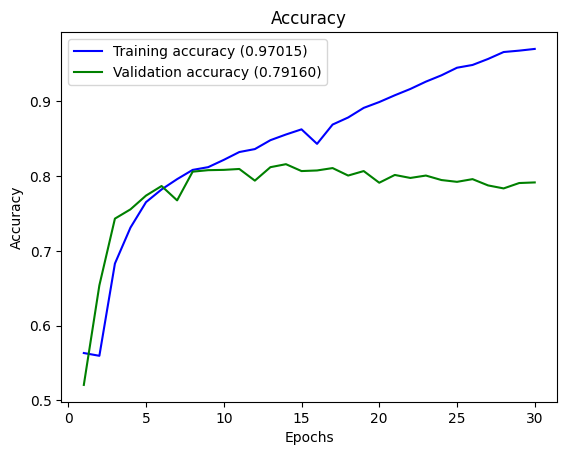

In [82]:
plot_history(accuracy_history, loss_history, val_accuracy_history, val_loss_history)

## <a id='toc2_4_'></a>[Glove 43B](#toc0_)

In [83]:
embeddings = read_glove_file('kaggle/glove.42B.300d/glove.42B.300d.txt')
train_data, validation_data, test_data, train_labels, validation_labels, test_labels, word_index, embedding_matrix = prepare_data_for_model(maxlen=100, max_words=10000, embeddings=embeddings, texts=texts, labels=labels, train_part=0.8, validation_part=0.1)

Found 1917494 word vectors.
['i', 'cannot', 'for', 'the', 'life', 'of', 'me', 'explain', 'what', 'the', 'popularity', 'of', 'the', 'children', "'", 's', 'television', 'show', ',', 'power', 'rangers', 'is', 'all', 'about', '.', 'br', '/', 'br', '/', 'i', 'never', 'understood', 'why', 'unsuspecting', 'children', 'liked', 'this', 'show', 'in', 'the', 'first', 'place', ',', 'since', 'the', 'characters', 'seem', 'so', 'idiotic', 'and', 'not', 'worth', 'caring', 'about', 'whatsoever', '.', 'br', '/', 'br', '/', 'the', 'costumes', 'look', 'completely', 'atrocious', ',', 'like', 'multi', 'colored', 'spandex', 'that', 'people', 'wear', 'to', 'go', 'to', 'the', 'gym', '.', 'br', '/', 'br', '/', 'what', 'exactly', 'is', 'the', 'purpose', 'of', 'this', 'show', 'anyways', ',', 'but', 'for', 'kids', 'to', 'learn', 'how', 'to']
Train data size: 20000
Validation data size: 2500
Test data size: 2500


In [84]:
train_dataset = torch.utils.data.TensorDataset(train_data, torch.tensor(train_labels, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(validation_data, torch.tensor(validation_labels, dtype=torch.long))
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(test_data, torch.tensor(test_labels, dtype=torch.long))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [85]:
model = RecurrentClassificationModelLSTM(vocab_size=10000, embed_size=300, maxlen=1000, hidden_size=64)
model.set_embedding(embedding_matrix)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
accuracy_history, loss_history, val_accuracy_history, val_loss_history = train_model(model, criterion, optimizer, train_loader, validation_loader)

Expected embedding shape: torch.Size([10000, 300])
Provided embedding matrix shape: (10000, 300)
Embedding shape: torch.Size([10000, 300])
Training model...


100%|██████████| 625/625 [00:05<00:00, 117.89it/s]


Epoch 1/30:
Train loss: 0.6327722193717956, accuracy: 0.6432
Validation loss: 0.6428225621392455, accuracy: 0.67


100%|██████████| 625/625 [00:05<00:00, 118.74it/s]


Epoch 2/30:
Train loss: 0.5932065172672272, accuracy: 0.69155
Validation loss: 0.6935288770289361, accuracy: 0.496


100%|██████████| 625/625 [00:04<00:00, 127.17it/s]


Epoch 3/30:
Train loss: 0.6112298803329468, accuracy: 0.6458
Validation loss: 0.5596047620984572, accuracy: 0.7176


100%|██████████| 625/625 [00:04<00:00, 127.04it/s]


Epoch 4/30:
Train loss: 0.4559625598669052, accuracy: 0.7854
Validation loss: 0.44812540427038944, accuracy: 0.7888


100%|██████████| 625/625 [00:04<00:00, 127.06it/s]


Epoch 5/30:
Train loss: 0.4186644344329834, accuracy: 0.8061
Validation loss: 0.4268891222869294, accuracy: 0.8004


100%|██████████| 625/625 [00:04<00:00, 126.75it/s]


Epoch 6/30:
Train loss: 0.3990348182439804, accuracy: 0.8185
Validation loss: 0.43126165980025183, accuracy: 0.7984


100%|██████████| 625/625 [00:04<00:00, 126.72it/s]


Epoch 7/30:
Train loss: 0.3809602479696274, accuracy: 0.8292
Validation loss: 0.39924421118973175, accuracy: 0.8032


100%|██████████| 625/625 [00:04<00:00, 127.64it/s]


Epoch 8/30:
Train loss: 0.36572742524147034, accuracy: 0.83805
Validation loss: 0.3906532486405554, accuracy: 0.8076


100%|██████████| 625/625 [00:04<00:00, 127.85it/s]


Epoch 9/30:
Train loss: 0.3476189050197601, accuracy: 0.84895
Validation loss: 0.40325993940800053, accuracy: 0.814


100%|██████████| 625/625 [00:04<00:00, 127.43it/s]


Epoch 10/30:
Train loss: 0.3314272808074951, accuracy: 0.856
Validation loss: 0.39928558695165417, accuracy: 0.8124


100%|██████████| 625/625 [00:04<00:00, 127.99it/s]


Epoch 11/30:
Train loss: 0.3084095550656319, accuracy: 0.87155
Validation loss: 0.4171160132258753, accuracy: 0.808


100%|██████████| 625/625 [00:04<00:00, 127.85it/s]


Epoch 12/30:
Train loss: 0.290398992729187, accuracy: 0.879
Validation loss: 0.4029839423638356, accuracy: 0.8132


100%|██████████| 625/625 [00:04<00:00, 127.77it/s]


Epoch 13/30:
Train loss: 0.26372163882255556, accuracy: 0.89465
Validation loss: 0.4612472210362365, accuracy: 0.8068


100%|██████████| 625/625 [00:04<00:00, 127.47it/s]


Epoch 14/30:
Train loss: 0.24169721776247025, accuracy: 0.9039
Validation loss: 0.44981089366387716, accuracy: 0.8136


100%|██████████| 625/625 [00:04<00:00, 127.11it/s]


Epoch 15/30:
Train loss: 0.21728970984220505, accuracy: 0.9157
Validation loss: 0.4862793059665946, accuracy: 0.8028


100%|██████████| 625/625 [00:04<00:00, 127.77it/s]


Epoch 16/30:
Train loss: 0.1964857561022043, accuracy: 0.9269
Validation loss: 0.5085276346417922, accuracy: 0.7968


100%|██████████| 625/625 [00:04<00:00, 127.60it/s]


Epoch 17/30:
Train loss: 0.17348685811460018, accuracy: 0.93425
Validation loss: 0.5190784491221362, accuracy: 0.81


100%|██████████| 625/625 [00:04<00:00, 127.64it/s]


Epoch 18/30:
Train loss: 0.15184055687189102, accuracy: 0.94305
Validation loss: 0.7075642411467395, accuracy: 0.7992


100%|██████████| 625/625 [00:04<00:00, 127.36it/s]


Epoch 19/30:
Train loss: 0.13533592463582755, accuracy: 0.95035
Validation loss: 0.6296741623855844, accuracy: 0.8016


100%|██████████| 625/625 [00:04<00:00, 127.21it/s]


Epoch 20/30:
Train loss: 0.11493780810385942, accuracy: 0.96005
Validation loss: 0.7154602220494158, accuracy: 0.8068


100%|██████████| 625/625 [00:04<00:00, 127.49it/s]


Epoch 21/30:
Train loss: 0.09951924997791647, accuracy: 0.9665
Validation loss: 0.704832755312135, accuracy: 0.7996


100%|██████████| 625/625 [00:04<00:00, 127.12it/s]


Epoch 22/30:
Train loss: 0.08230414894968271, accuracy: 0.97275
Validation loss: 0.8470557042503659, accuracy: 0.7936


100%|██████████| 625/625 [00:04<00:00, 125.52it/s]


Epoch 23/30:
Train loss: 0.07826086411625147, accuracy: 0.9737
Validation loss: 0.895572836655251, accuracy: 0.7964


100%|██████████| 625/625 [00:04<00:00, 126.21it/s]


Epoch 24/30:
Train loss: 0.06172826825529337, accuracy: 0.98045
Validation loss: 0.974972137167484, accuracy: 0.7928


100%|██████████| 625/625 [00:05<00:00, 124.55it/s]


Epoch 25/30:
Train loss: 0.0631444992467761, accuracy: 0.98045
Validation loss: 1.0050313963165767, accuracy: 0.7948


100%|██████████| 625/625 [00:04<00:00, 127.00it/s]


Epoch 26/30:
Train loss: 0.059063076863996686, accuracy: 0.98035
Validation loss: 0.9786750321582998, accuracy: 0.7952


100%|██████████| 625/625 [00:04<00:00, 127.09it/s]


Epoch 27/30:
Train loss: 0.044029815273266285, accuracy: 0.98625
Validation loss: 1.0238803677921053, accuracy: 0.7968


100%|██████████| 625/625 [00:04<00:00, 127.00it/s]


Epoch 28/30:
Train loss: 0.04277586432769895, accuracy: 0.9861
Validation loss: 1.1096447479875782, accuracy: 0.8052


100%|██████████| 625/625 [00:04<00:00, 126.77it/s]


Epoch 29/30:
Train loss: 0.04791030906289816, accuracy: 0.98415
Validation loss: 1.0773710168992416, accuracy: 0.7972


100%|██████████| 625/625 [00:04<00:00, 125.89it/s]


Epoch 30/30:
Train loss: 0.036196575312688946, accuracy: 0.9891
Validation loss: 0.9951119766794617, accuracy: 0.7928


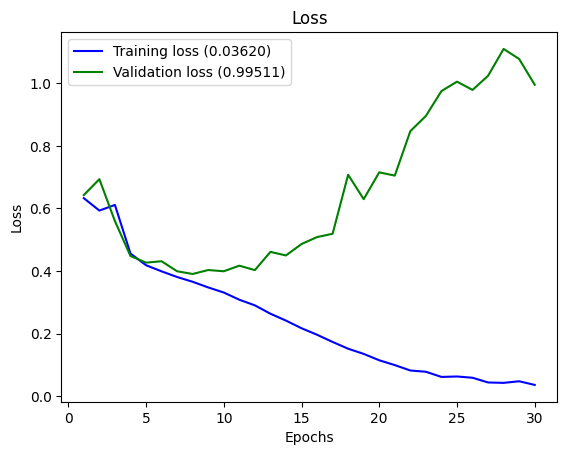

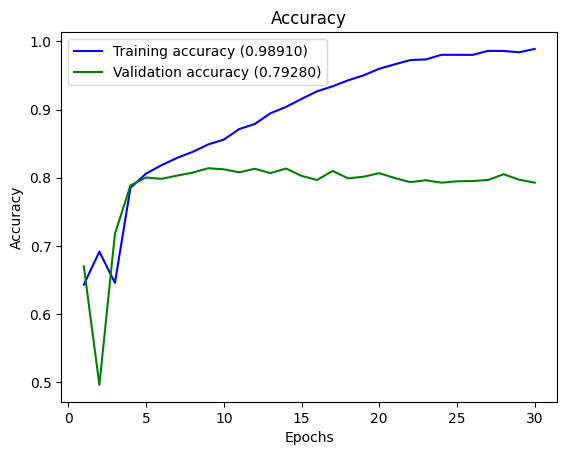

In [86]:
plot_history(accuracy_history, loss_history, val_accuracy_history, val_loss_history)

# <a id='toc3_'></a>[Conclusion](#toc0_)

In this notebook, I again decided in favour of implementing the whole thing in PyTorch. In order to get satisfactory accuracy, this task proved to be a bit more challenging than I anticipated, but in the end I managed to get a decent result. This being said, I am not entirely satisfied with the result, but I am happy with the knowledge I gained in the process.

Stuff I've learned:
- PyTorch practice
- Embeddings and how to use them
- Embedded layers in PyTorch
- LSTM (what it is and how to use it)